In [2]:
import scipy.io
import pandas as pd
from elephant.gpfa import GPFA
import numpy as np
import quantities as pq
import neo
import pickle
import matplotlib.pyplot as plt
plt.style.use('dark_background')

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)


load gpfa data

In [9]:
with open('data/spikeTimes.pickle', 'rb') as filename:
    st = pickle.load(filename)

In [10]:
numTrials = len(st)
numNeurons = len(st[0])

Raster Plot

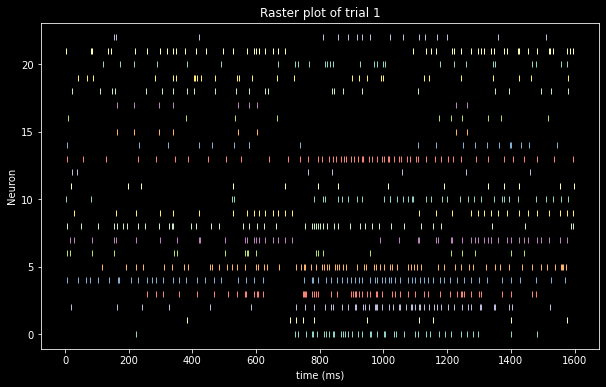

In [12]:
fig = plt.figure(figsize=(10,6))
for i, spiketrain in enumerate(st[0]):
    plt.plot(spiketrain, np.ones_like(spiketrain)*i, ls='', marker='|')

plt.title('Raster plot of trial 1')
plt.xlabel('time (ms)')
plt.ylabel('Neuron')
plt.show()

Apply GPFA (fit with first 20 trials for computational ease)

In [17]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [18]:
gpfa_2dim.fit(st[:numTrials//2])
print(gpfa_2dim.params_estimated.keys())

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 5 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 5 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 280 EM iterations.)
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [19]:
trajectories = gpfa_2dim.transform(st[numTrials//2:])

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 15 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 11 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

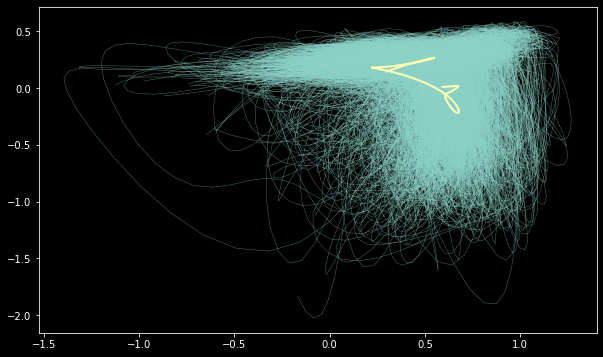

In [20]:
fig = plt.figure(figsize=(10,6))


linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

# single trial trajectories
for single_trial_trajectory in trajectories:
    plt.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
plt.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')

plt.show()


In [21]:
# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(st)

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 5 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 11 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 365 EM iterations.)


/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 5 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 6 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 5 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/opt/anaconda3/envs/elephant_e

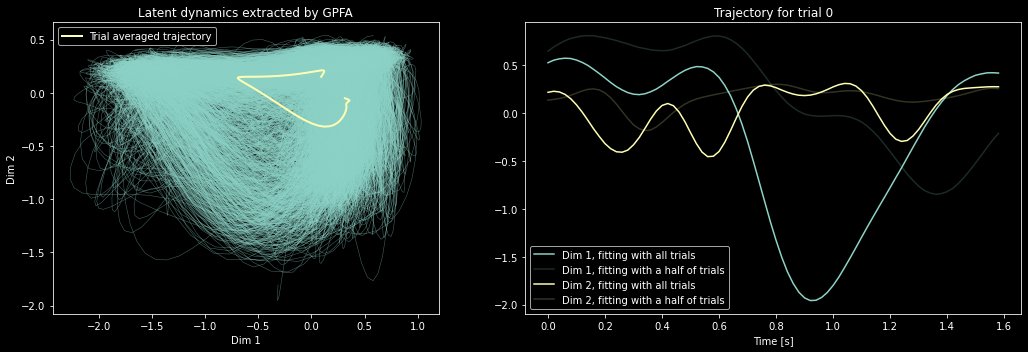

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()